# Introduction

In this project, I will create a deep learning model to classify images of skin lesions into one of seven classes:

1.   "MEL" = Melanoma
2.   "NV" = Melanocytic nevus
3.   "BCC" = Basal cell carcinoma
4.   "AKIEC" = Actinic keratosis
5.   "BKL" = Benign keratosis
6.   "DF" = Dermatofibroma
7.   "VASC" = Vascular lesion

The data for this task is a subset of: https://challenge2018.isic-archive.com/task3/

It contains ~3,800 images named like `ISIC_000000.jpg` and the following label files:

*   `/content/data/img/train.csv`
*   `/content/data/img/val.csv`
*   `/content/data/img/train_small.csv`
*   `/content/data/img/val_small.csv`

The `small` versions are the first 200 lines of each partition and are included for debugging purposes. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory for the project
import os
SKELETON_DIR = '/content/drive/MyDrive/...'
os.chdir(SKELETON_DIR)
! mkdir -p "$SKELETON_DIR/saved_models"
! mkdir -p "$SKELETON_DIR/logs"

# Set up auto-reloading modules from the working directory
%load_ext autoreload
%autoreload 2

# Install extra dependencies
!pip install -q wandb==0.15.0
!pip install -q torchmetrics==0.11.3

# Set the default figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

In [ ]:
%%shell
DATA_URL='https://my.sharepoint.com/:u:/g/personal/chloe/Edn2-_XuX2pGptMfH6eVLIoB16_ofpRlZnCf6rwP47EkBQ?e=ogAWGM&download=1'

pushd /content
wget -O data.zip $DATA_URL
unzip -q data.zip
popd


## Explore the training set

In [ ]:
import pandas as pd

IMG_CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

train_df = pd.read_csv('/content/data/img/train.csv')
val_df = pd.read_csv('/content/data/img/val.csv')
train_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot Class Distribution

[1 1 1 ... 1 1 1]


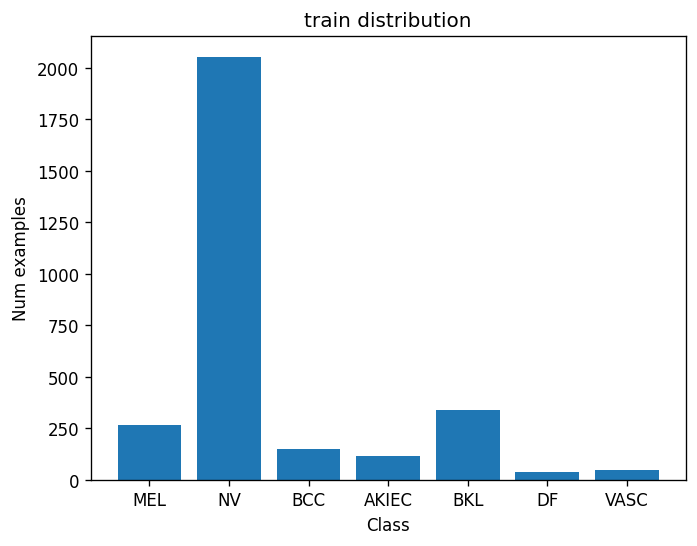

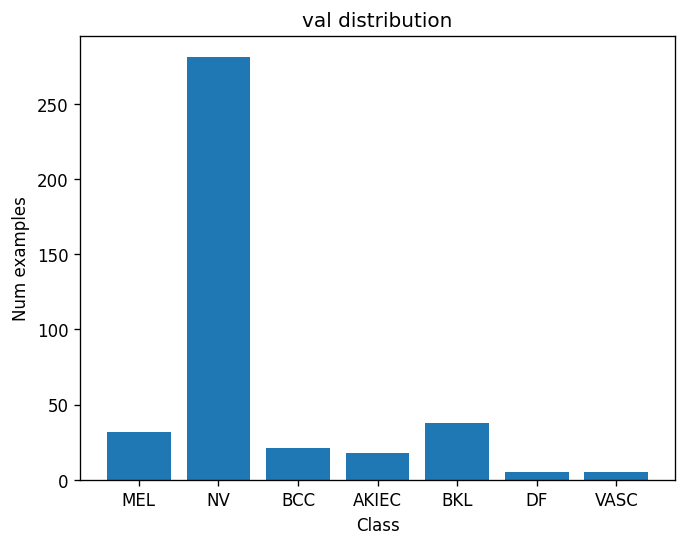

In [ ]:
import explore

train_labels = train_df.values[:, 1:].argmax(axis=1)
val_labels = val_df.values[:, 1:].argmax(axis=1)

print(train_labels)

# Plot the class distributions
explore.plot_label_distribution(train_labels, 'train', IMG_CLASS_NAMES)
explore.plot_label_distribution(val_labels, 'val', IMG_CLASS_NAMES)

### Check for Missing Data

In [ ]:
train_df.isnull().sum()

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64

In [ ]:
val_df.isnull().sum()

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64

## Instantiate the Dataset

In [ ]:
import datasets

ds = datasets.LesionDataset('/content/data/img',
                            '/content/data/img/train.csv', train_mode=True, test_mode=False)
input, label = ds[0]
print(input.shape)
print(label)

torch.Size([3, 224, 224])
1


## Implement a baseline convolutional neural network

Implement a baseline convolutional neural network to compare results to. This allows us to evaluate any improvements made by hyperparameter tuning or transfer learning.

The code for this part can be found in the `models.py` file. 

## Account for data issues

Our dataset has a class imbalance issue. We could address this using two techniques, weighted random sampler and weighted loss function. 

The code to implement this can be found in the `Model Training Cell` section below, and the results are detailed in the Written Report. Besides accuracy and unweighted average recall, I also plotted a Confusion Matrix to demonstrate how effective each technique was. 

## Data Augmentation

Data augmentation is a popular technique to improve model performance. In this project, I tried 6 different data augmentations techniques, including random flips, random rotation, color jitter, random perspective, and random invert. The code for this part can be found in the `datasets.py` file, and the results are detailed in the Written Report. 

## Chase improved performance

I tried different techniques to improve the model performance, including transfer learning, increasing the baseline model's depth and width, fine-tuning learning rates, increasing the number of training epochs, experimenting with different activation functions, and changing the batch size. 

The training results of these different models are recorded in the attached Excel spreadsheet. In summary, I was able to achieve the highest validation accuracy of 85.5% with the fine-tuned Resnet152 model, and highest validation UAR of 76.55% with the final model which combined fine-tuned Resnet152 with the best performing techniques and hyperparameters previously tried, including Random Rotation and Weighted Random Sampler.

<a name="task-1-model-training"></a>
## Model Training Cell

I will be using Weights and Biases to keep track of my experimental runs and evaluation metrics. 


### Training different models

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import datasets
import models
import train

# Set the seed for reproducible results
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(random_seed)

NUM_EPOCHS = 5
BATCH_SIZE = 64

# Create datasets/loaders
# Create the data loaders from LesionDatasets

train_dataset = datasets.LesionDataset('/content/data/img',
                              '/content/data/img/train.csv',
                              train_mode=True, test_mode=False, augment=False) 
val_dataset = datasets.LesionDataset('/content/data/img',
                            '/content/data/img/val.csv',
                            train_mode=False, test_mode=True)

train_loader= DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate model, optimizer and criterion
#model = models.SimpleBNConv()
model = models.construct_resnet152()
#model = models.EnhancedBNConv()
model.to(train.device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train model

train.train_model(model, train_loader, val_loader, optimizer, criterion,
                  IMG_CLASS_NAMES, NUM_EPOCHS, project_name="Skin Cancer Detection",
                  ident_str= "lr 0.0001")

### Weighted Random Sampler

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▆▇▇██████
Accuracy_val,▁▅▆▆▆▆▆▇█▇
Loss_train,█▃▂▂▁▁▁▁▁▁
Loss_val,█▃▃▂▃▃▃▂▁▁
UAR_train,▁▆▇▇██████
UAR_val,▂▃█▂▅▄▁▆▅▇
Accuracy_train,0.97703
Accuracy_val,0.835
Loss_train,0.07604
Loss_val,0.50764
UAR_train,0.97781


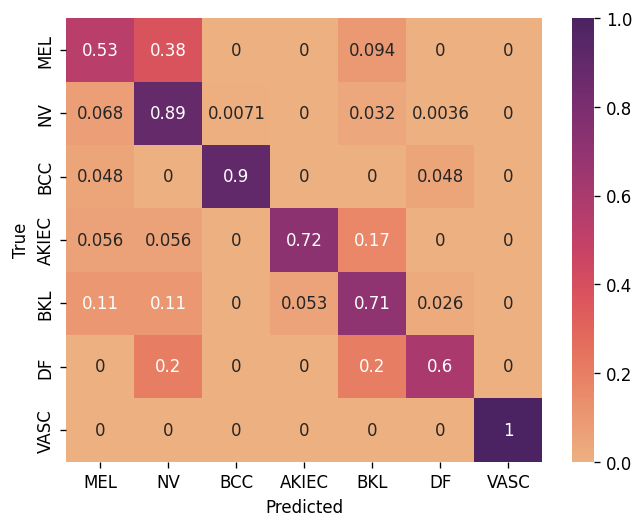

In [ ]:
# Account for Class Imbalance using Weighted Random Sampler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import datasets
import models
import train

# Set the seed for reproducible results
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(random_seed)

NUM_EPOCHS = 10
BATCH_SIZE = 64

# Initialise two instances of LesionDataset - one each for train and validation.
train_dataset = datasets.LesionDataset('/content/data/img',
                              '/content/data/img/train.csv',
                              train_mode=True, test_mode=False, augment=True)
val_dataset = datasets.LesionDataset('/content/data/img',
                            '/content/data/img/val.csv',
                            train_mode=False, test_mode=True, augment=False)

# Calculate class weights to use in the Weighted Random Sampler

# Calculate the proportion of each class
class_counts = np.bincount(train_labels)
class_proportions = class_counts / len(train_labels)

# Invert the proportions to get weights
class_weights = 1.0 / class_proportions

# Normalize the weights so they add up to 1
total_weight = np.sum(class_weights)
normalized_class_weights = class_weights / total_weight

# Map the normalized weights to each sample
sample_weights = [normalized_class_weights[label] for label in train_labels]

# Initialise a WeightedRandomSampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(train_labels))

# Instantiate the train and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate model, optimizer and criterion
#model = models.SimpleBNConv(train.device)
model = models.construct_resnet152().to(train.device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train model
train.train_model(model, train_loader, val_loader, optimizer, criterion,
                  IMG_CLASS_NAMES, NUM_EPOCHS, project_name="CSE3DL Assignment",
                  ident_str= "BestModel + 10 epochs")

### Weighted Loss Function

wandb: Currently logged in as: dophuongnga203 (latrobe01). Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy_train,▁▃▇█▆
Accuracy_val,█▃▁▃▅
Loss_train,█▆▄▁▂
Loss_val,█▅▆▁▆
UAR_train,▁▃▄█▇
UAR_val,▁▃▂█▄
Accuracy_train,0.40712
Accuracy_val,0.4875
Loss_train,1.62453
Loss_val,1.64062
UAR_train,0.37538


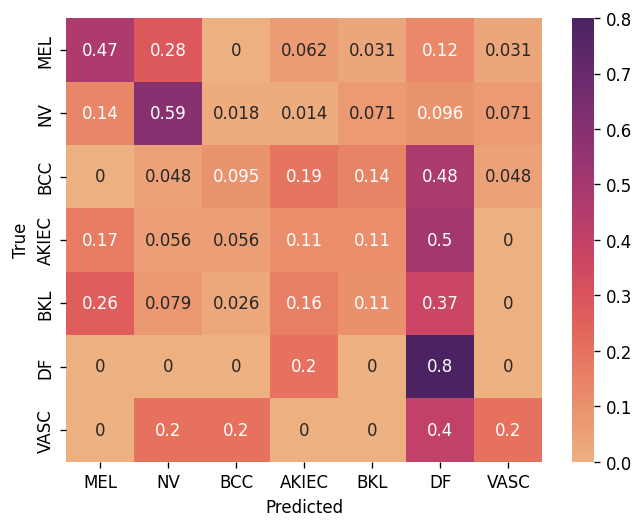

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import datasets
import models
import train

# Set the seed for reproducible results
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(random_seed)

NUM_EPOCHS = 5
BATCH_SIZE = 64

# Create datasets/loaders

# Initialise two instances of LesionDataset - one each for train and validation.

train_dataset = datasets.LesionDataset('/content/data/img',
                              '/content/data/img/train.csv',
                              train_mode=True, test_mode=False, augment=False)
val_dataset = datasets.LesionDataset('/content/data/img',
                            '/content/data/img/val.csv',
                            train_mode=False, test_mode=True, augment=False)

# Calculate class weights to use in the Weighted Loss Function

# Calculate the proportion of each class
class_counts = np.bincount(train_labels)
class_proportions = class_counts / len(train_labels)

# Invert the proportions to get weights
class_weights = 1.0 / class_proportions

# Normalize the weights so they add up to 1
total_weight = np.sum(class_weights)
normalized_class_weights = class_weights / total_weight

# Create weighted loss function
weights = torch.tensor(normalized_class_weights, dtype=torch.float32).to(train.device)
weighted_loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Instantiate the train and validation dataloaders

train_loader= DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate model, optimizer and criterion

model = models.SimpleBNConv(train.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Use the created Weighted Loss Function
criterion = weighted_loss_fn

# Train model

train.train_model(model, train_loader, val_loader, optimizer, criterion,
                  IMG_CLASS_NAMES, NUM_EPOCHS, project_name="CSE3DL Assignment",
                  ident_str= "Weighted Loss Function")